In [1]:
%run functions.ipynb

Ready: 2023-05-22 01:07:33


In [2]:
findspark.init()
from pyspark.sql import SparkSession
try:
    spark.stop()
except:
    pass
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

spark

In [197]:
df1 = pd.read_parquet(f'files/ten_city/df_dates_users_city_agg')
df1 = df1[df1['city'] == city]
df1['city_rubric_param'] = df1['city'] + '. ' + df1['rubric'] + '. ' + 'Пользователи'
df1 = df1[['date_r', 'cnt_users', 'city_rubric_param']].rename({'cnt_users':'cnt'}, axis=1)

df2 = pd.read_parquet(f'files/ten_city/df_dates_users_city_agg')
df2 = df2[df2['city'] == city]
df2['city_rubric_param'] = df2['city'] + '. ' + df2['rubric'] + '. ' + 'Запросы'
df2 = df2[['date_r', 'cnt_requests', 'city_rubric_param']].rename({'cnt_requests':'cnt'}, axis=1)
df_dates_users = pd.concat([df1, df2])

df_dates_users['cnt_all'] = df_dates_users.groupby('city_rubric_param')['cnt'].transform(np.sum)
df_dates_users['city_rubric_param_cnt'] = df_dates_users['cnt_all'].astype(str) + '_' + df_dates_users['city_rubric_param']

dfx = pd.pivot_table(df_dates_users, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric_param_cnt'])
t = dfx.corr().fillna(0).astype(np.float16)

t = t.rename_axis([None]).rename_axis([None], axis=1)
t1 = t.stack()
t1 = t1.reset_index()
t1.columns = ['r1', 'r2', 'corr']
t1 = t1[t1.r1 != t1.r2]

t1_100 = df_100.merge(t1, left_on='cnt_city_rubric', right_on='r1')

t1_100['r1_cnt'] = t1_100.r1.apply(lambda x: x.split('_')[0])
t1_100['r2_cnt'] = t1_100.r2.apply(lambda x: x.split('_')[0])

t1_100.r1 = t1_100.r1.apply(lambda x: x.split('_')[1])
t1_100.r2 = t1_100.r2.apply(lambda x: x.split('_')[1])
t1_100['r1_city'] = t1_100.r1.apply(lambda x: x.split('. ')[0])
t1_100['r2_city'] = t1_100.r2.apply(lambda x: x.split('. ')[0])
t1_100['r1_rubric'] = t1_100.r1.apply(lambda x: x.split('. ')[1])
t1_100['r2_rubric'] = t1_100.r2.apply(lambda x: x.split('. ')[1])
t1_100['r1_param'] = t1_100.r1.apply(lambda x: x.split('. ')[2])
t1_100['r2_param'] = t1_100.r2.apply(lambda x: x.split('. ')[2])

t1_100.r1_cnt = t1_100.r1_cnt.astype(int)
t1_100.r2_cnt = t1_100.r2_cnt.astype(int)

t1_100 = t1_100[t1_100.r2_cnt > 1000]

t1_100 = t1_100[['r1', 'r2', 'r1_city', 'r1_rubric', 'r1_param', 'r2_city', 'r2_rubric', 'r2_param', 'corr', 'r1_cnt', 'r2_cnt']]

df_100.shape, t1_100.shape

((2872, 7), (4033755, 9))

In [229]:
t2 = t1_100[(t1_100.r1_cnt > 10000) & (t1_100.r2_cnt > 10000)]
t2['cnt_diff'] = abs(t2.r1_cnt - t2.r2_cnt)
t1_m = t2[t2['corr'] < 0].sort_values(['cnt_diff', 'r1_cnt'], ascending=[True, False])
fpath = Path(mpl.get_data_path(), r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\Лого\arialnarrow.ttf")
size_x=17.5 / 2.54 * 4
size_y=10.8   / 2.54 * 4

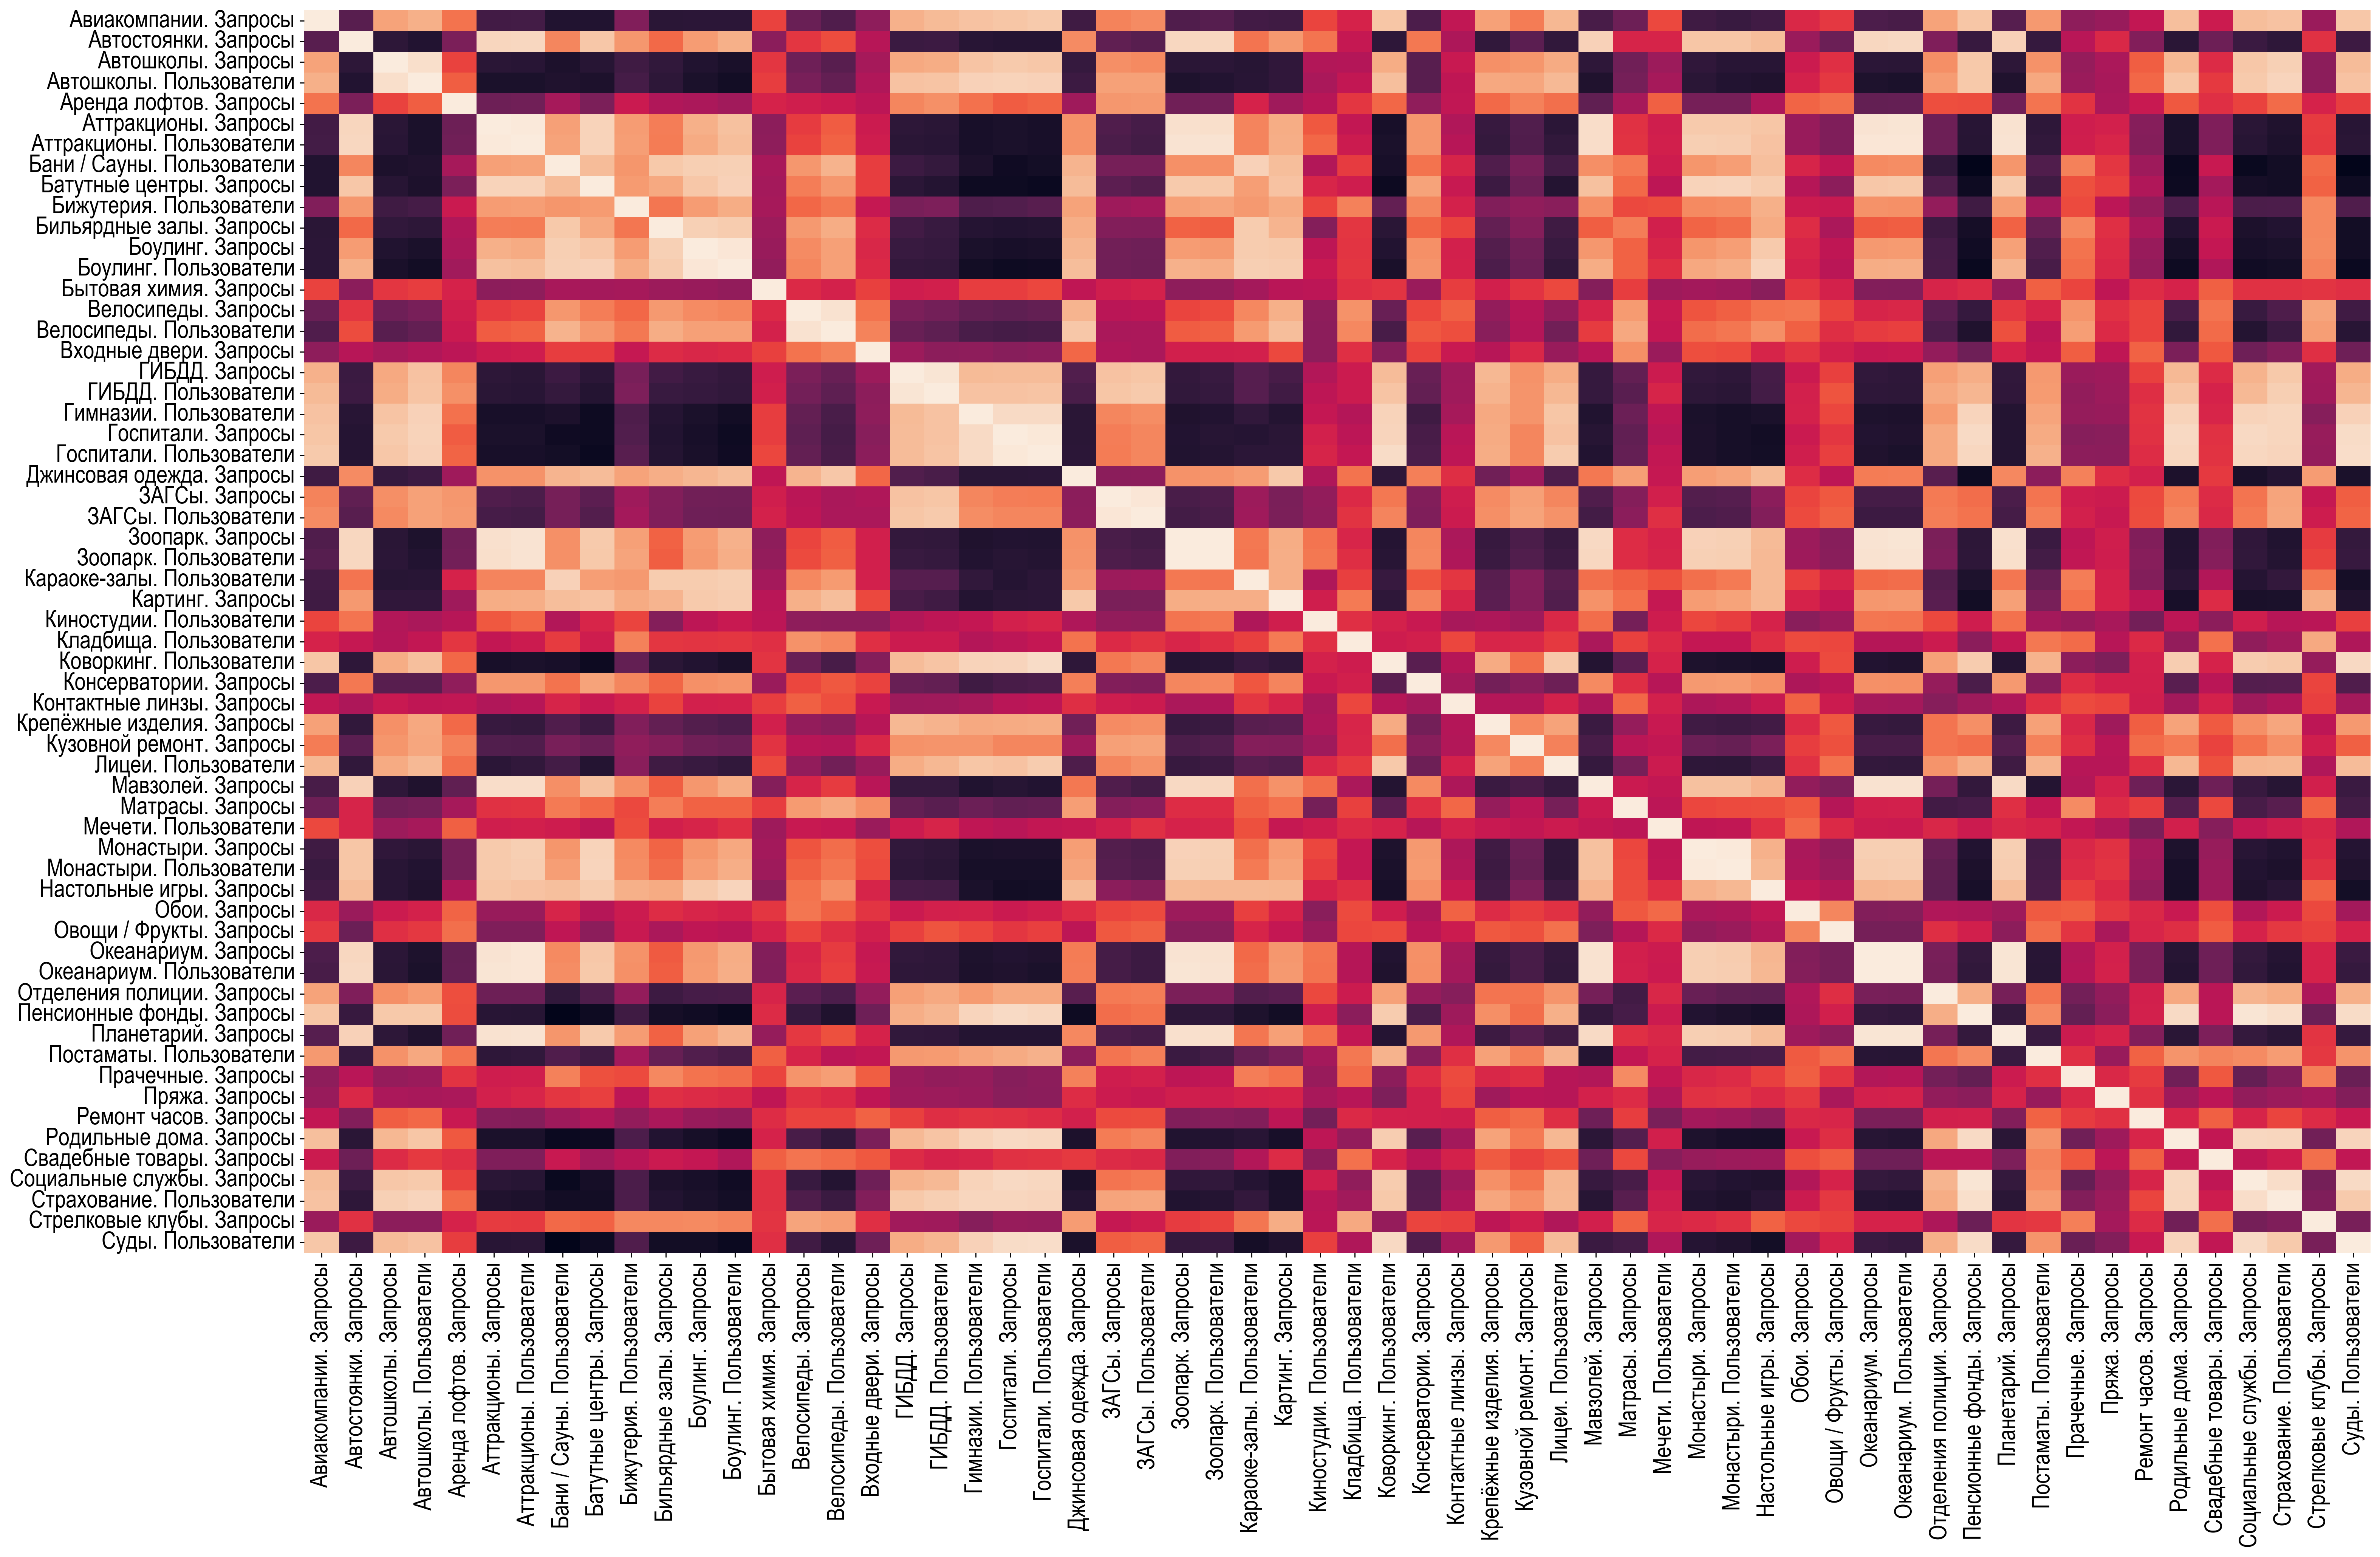

In [235]:
negative_corr = t1_m.iloc[:1000]
negative_corr_rubrics = pd.concat([negative_corr.r1, negative_corr.r2])_rubric.drop_duplicates().values
#negative_corr_rubrics = [i.replace('Москва. ', '') for i in negative_corr_rubrics]

df_dates_negative = df_dates_users[df_dates_users['city_rubric_param'].apply(lambda x: ((x in negative_corr_rubrics) and (len(x) < 35)))]
df_dates_negative['city_rubric_param'] = df_dates_negative['city_rubric_param'].apply(lambda x: x.replace('Москва. ',''))
dfx = pd.pivot_table(df_dates_negative, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric_param']).iloc[:60,:60]
t = dfx.corr().fillna(0)

fig, ax = plt.subplots()
ax = sns.heatmap(t, annot=False, cbar=False)
plt.xticks(font=fpath, fontsize=18)
plt.yticks(font=fpath, fontsize=18)
plt.rcParams['figure.dpi'] = 2**8
plt.rcParams['figure.figsize']=size_x,size_y
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'corr_matrix.png', bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

In [ ]:
positive_corr = t2[t2['corr'] >= 0.99]
positive_corr_rubrics = pd.concat([positive_corr.r1, positive_corr.r2])_rubric.drop_duplicates().values
positive_corr_rubrics = [i.split('_')[1] for i in positive_corr_rubrics]

df_dates_positive = df_dates_all[df_dates_all['city_rubric'].apply(lambda x: ((x in positive_corr_rubrics[:50]) and (len(x) < 35)))]

dfx = pd.pivot_table(df_dates_positive, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric']).iloc[:30,:30]
t = dfx.corr().fillna(0)

fig, ax = plt.subplots()
ax = sns.heatmap(t, annot=True, cbar=False)
plt.xticks(font=fpath, fontsize=24)
plt.yticks(font=fpath, fontsize=24)
plt.rcParams['figure.dpi'] = 2**8
plt.rcParams['figure.figsize']=size_x,size_y
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'corr_matrix_1.png', bbox_inches='tight', transparent=False)
#plt.show()

In [ ]:
negative_corr = t1_m.iloc[:500]
negative_corr_rubrics = pd.concat([negative_corr.r1, negative_corr.r2])_rubric.drop_duplicates().values
negative_corr_rubrics = [i.split('_')[1] for i in negative_corr_rubrics]

df_dates_negative = df_dates_all[df_dates_all['city_rubric'].apply(lambda x: (x in negative_corr_rubrics[:500]) and (len(x) < 35))]

dfx = pd.pivot_table(df_dates_negative, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric']).iloc[:25,:25]
t = dfx.corr().fillna(0)

fig, ax = plt.subplots()
ax = sns.heatmap(t, annot=True, cbar=False)
plt.xticks(font=fpath, fontsize=24)
plt.yticks(font=fpath, fontsize=24)
plt.rcParams['figure.dpi'] = 2**8
plt.rcParams['figure.figsize']=size_x,size_y
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'corr_matrix_2.png', bbox_inches='tight', transparent=False)
plt.show()

In [ ]:
zero_corr = t1[t1['corr'] < abs(0.41)]
zero_corr_rubrics = pd.concat([zero_corr.r1, zero_corr.r2])_rubric.drop_duplicates().values
zero_corr_rubrics = [i.split('_')[1] for i in zero_corr_rubrics]

In [ ]:
df_dates_zero = df_dates_all[df_dates_all['city_rubric'].apply(lambda x: (x in zero_corr_rubrics[:500]) and (len(x) < 35) )]

dfx = pd.pivot_table(df_dates_zero, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric']).iloc[:30,:30]
t = dfx.corr().fillna(0)

fig, ax = plt.subplots()
ax = sns.heatmap(t, annot=True, cbar=False)
plt.xticks(font=fpath, fontsize=24)
plt.yticks(font=fpath, fontsize=24)
plt.rcParams['figure.dpi'] = 2**8
plt.rcParams['figure.figsize']=size_x,size_y
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'corr_matrix_3.png', bbox_inches='tight', transparent=False)
plt.show()